In [1]:
import numpy as np
import os

The Navier-Stokes equations are being solved for incompressible flow around a cylinder. These equations are a set of partial differential equations (PDEs) governing the motion of fluid substances. For a 2D incompressible, viscous flow, they can be written in the Cartesian coordinate system as follows:

## Continuity Equation:

The continuity equation represents the conservation of mass, stating that the mass entering a control volume must equal the mass exiting the volume, plus any change in mass within the volume. For an incompressible flow, it simplifies to:

$$ \nabla u = 0 $$

or, in a two-dimensional form:

$$
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\tag{1}
\end{equation}
$$

where u and v are the velocity components in the x and y directions respectively.

## Momentum Equations:

The momentum equations represent the conservation of momentum. They are the result of applying Newton's second law (force equals the rate of change of momentum) to fluid motion. The Navier-Stokes equations include the effects of viscosity, which are modeled with a Laplacian operator. The momentum equations for an incompressible flow can be written as:

$$
\begin{equation}
\rho \left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \nu \nabla^2 u
\tag{2}
\end{equation}
$$
$$
\begin{equation}
\rho \left( \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \nu \nabla^2 v
\tag{3}
\end{equation}
$$

where:

ρ is the fluid density
u, v are the velocity components in the x and y directions, respectively
t is time
p is pressure
ν is the kinematic viscosity
∇² is the Laplacian operator, denoting the divergence of the gradient of a scalar field, here used to represent the diffusion of momentum (due to viscosity)
The pressure-Poisson equation is also used to enforce incompressibility.

$$
\begin{equation}
\nabla^2 p = \nabla \cdot (\rho \vec{u} \cdot \nabla \vec{u}) - \rho \frac{\partial}{\partial t} (\nabla \cdot \vec{u})
\end{equation}
$$


In [2]:
xmax = 1.0
ymax = 1.0
tmax = 0.1

nx = 64
ny = 64
nt = 1000

dx = xmax / (nx - 1)
dy = ymax / (ny - 1)
dt = tmax / (nt - 1)

nit=50 
c = 1

x = np.linspace(0, xmax, nx)
y = np.linspace(0, ymax, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1

u = np.zeros((ny, nx))  # velocity field
v = np.zeros((ny, nx))  # velocity field
p = np.zeros((ny, nx))  # pressure field
b = np.zeros((ny, nx))  # RHS for pressure equation

def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                              2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                               ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()

    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]  # dp/dy = 0 at x = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

# Define the cylinder
center = [0.5, 0.5]  # center of the cylinder
radius = 0.1  # radius of the cylinder
cylinder = np.sqrt((X - center[0])**2 + (Y - center[1])**2) < radius

# Initialize the mask for u and v with ones
u_mask = np.ones_like(u)
v_mask = np.ones_like(v)

# Set u and v to zero inside the cylinder
u_mask[cylinder] = 0
v_mask[cylinder] = 0

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    # Create lists to store the field data
    u_data = []
    v_data = []
    p_data = []
    t_data = []

    # Create a directory to store the CSV files
    os.makedirs('csv_files', exist_ok=True)

    for n in range(nt):
        un = u.copy()
        vn = v.copy()
            
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        # Add the mask to the u and v equations
        u = un * u_mask - un * u_mask * dt / dx * (un * u_mask - np.roll(un * u_mask, 1, axis=1)) \
                - vn * u_mask * dt / dy * (un * u_mask - np.roll(un * u_mask, 1, axis=0)) \
                - dt / (2 * rho * dx) * (np.roll(p, -1, axis=1) - np.roll(p, 1, axis=1)) \
                + nu * (dt / dx**2 * (np.roll(un * u_mask, -1, axis=1) - 2 * un * u_mask + np.roll(un * u_mask, 1, axis=1)) \
                + dt / dy**2 * (np.roll(un * u_mask, -1, axis=0) - 2 * un * u_mask + np.roll(un * u_mask, 1, axis=0)))

        v = vn * v_mask - un * v_mask * dt / dx * (vn * v_mask - np.roll(vn * v_mask, 1, axis=1)) \
                - vn * v_mask * dt / dy * (vn * v_mask - np.roll(vn * v_mask, 1, axis=0)) \
                - dt / (2 * rho * dy) * (np.roll(p, -1, axis=0) - np.roll(p, 1, axis=0)) \
                + nu * (dt / dx**2 * (np.roll(vn * v_mask, -1, axis=1) - 2 * vn * v_mask + np.roll(vn * v_mask, 1, axis=1)) \
                + dt / dy**2 * (np.roll(vn * v_mask, -1, axis=0) - 2 * vn * v_mask + np.roll(vn * v_mask, 1, axis=0)))
        
        # Reset the velocity inside the cylinder to zero
        u[cylinder] = 0
        v[cylinder] = 0

        # Left boundary (inflow)
        u[:, 0] = 1
        v[:, 0] = 0

        # Right boundary (outflow)
        u[:, -1] = u[:, -2]
        v[:, -1] = v[:, -2]

        # Top and bottom boundaries (symmetry)
        u[0, :] = u[1, :]
        v[0, :] = 0
        u[-1, :] = u[-2, :]
        v[-1, :] = 0

        # Append the current u, v, and p to the data lists
        u_data.append(u.copy())
        v_data.append(v.copy())
        p_data.append(p.copy())
        t_data.append(n*dt)

        # Save u, v, and p to CSV files
        np.savetxt(f'csv_files/u_{n}.csv', u, delimiter=',')
        np.savetxt(f'csv_files/v_{n}.csv', v, delimiter=',')
        np.savetxt(f'csv_files/p_{n}.csv', p, delimiter=',')
        
    return u_data, v_data, p_data

In [3]:
u_data, v_data, p_data = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
u = u_data[-1]
v = v_data[-1]
p = p_data[-1]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

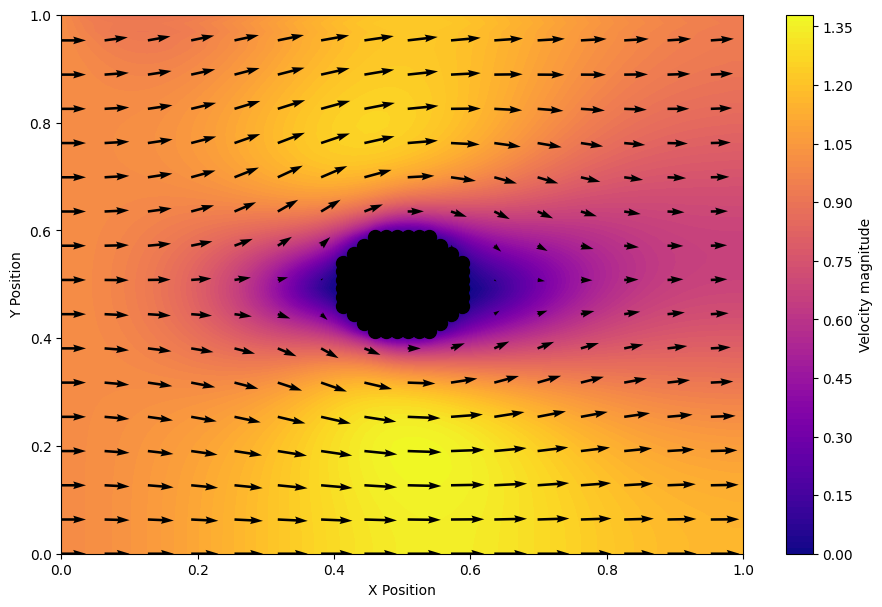

In [5]:
fig, ax = plt.subplots(figsize=(11, 7))

# Compute the velocity magnitude
magnitude = np.sqrt(u**2 + v**2)

# Plotting the velocity magnitude field
contour = ax.contourf(X, Y, magnitude, alpha=1, cmap=cm.plasma, levels=100)
fig.colorbar(contour, ax=ax, label='Velocity magnitude')

# Plotting the velocity field
quiver = ax.quiver(X[::4, ::4], Y[::4, ::4], u[::4, ::4], v[::4, ::4])

# Plotting the cylinder
ax.scatter(X[cylinder], Y[cylinder], color='black', s=100)

# Adding labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

plt.show()

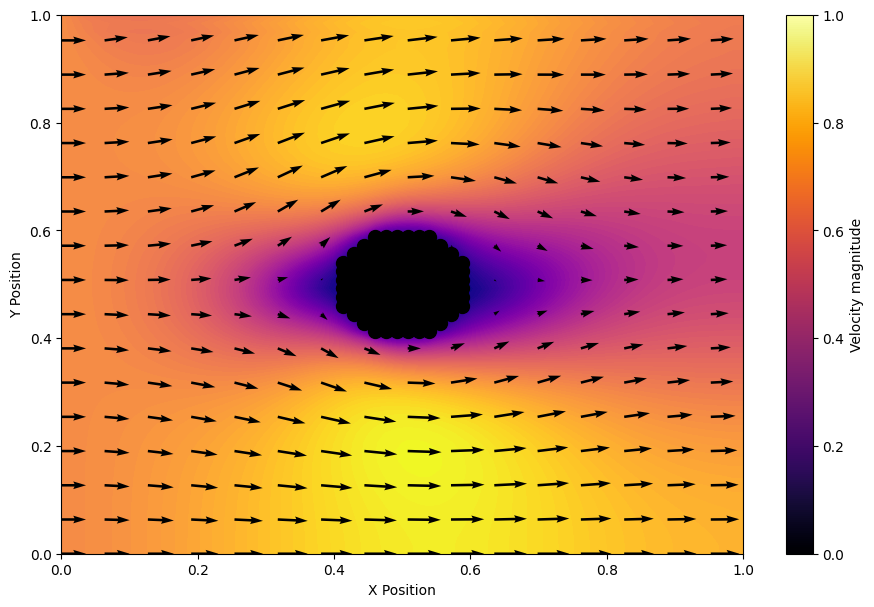

In [6]:
import matplotlib.animation as animation
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(11, 7))

# Adding labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

# Initialization function for the animation
def init():
    return []

# Animation update function
def update(num, u_data, v_data, X, Y, cylinder):
    # Clear the current axes.
    plt.cla()

    # Compute the velocity magnitude for the current timestep
    magnitude = np.sqrt(u_data[num]**2 + v_data[num]**2)

    # Create a new contour plot for the velocity magnitude
    contour = ax.contourf(X, Y, magnitude, alpha=1, cmap=cm.plasma, levels=100)

    # Create a new quiver plot for the velocity field
    quiver = ax.quiver(X[::4, ::4], Y[::4, ::4], u_data[num][::4, ::4], v_data[num][::4, ::4])

    # Create a new scatter plot for the cylinder
    cylinder_plot = ax.scatter(X[cylinder], Y[cylinder], color='black', s=100)

    # Adding labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    return contour, quiver, cylinder_plot,

# Create the animation
step = int(len(u_data) / 50)
ani = animation.FuncAnimation(fig, update, frames=range(0, len(u_data), step), init_func=init, fargs=(u_data, v_data, X, Y, cylinder), blit=False)

# Create a ScalarMappable object
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=norm)
sm.set_array([])

# Add a colorbar to the figure using the ScalarMappable object
fig.colorbar(sm, ax=ax, label='Velocity magnitude')

# Save the animation
ani.save('flow_animation.gif', writer='pillow')